In [1]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
from visual_behavior_glm.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.__version__

'0.11.0'

In [69]:
%matplotlib notebook
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [4]:
rs = gat.retrieve_results(search_dict = {'glm_version': '6_L2_optimize_by_session'}, results_type='summary')
rs.sample(10)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc
625073,5f4fd1ca745200ee0a47e360,single-running,-0.029094,0.005256,0.034350,-0.153016,1028819930,-0.153150,0.005257,0.034324,974358973,973701907,973744975,1018027828,VisualBehaviorMultiscope,completed,passed,20191029_484627_Ophys4,OPHYS_4_images_B,MESO.1,2019-10-29 10:41:35.836194,943395690,930825455,M,113.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",261,VISp,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_261,0,4,6_L2_optimize_by_session,2020-09-02 17:09:30.444589
569028,5f4fd1c222d0d203ad6938ff,misses,-0.000216,0.030406,0.030622,-0.007045,1028826524,-0.040389,0.021388,0.022288,974994099,974486549,974634733,1018027828,VisualBehaviorMultiscope,completed,passed,20191031_484627_Ophys6,OPHYS_6_images_B,MESO.1,2019-10-31 08:26:06.328780,943395690,930825455,M,115.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",279,VISp,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_279,0,6,6_L2_optimize_by_session,2020-09-02 17:09:22.384112
2661981,5f5178eae11ac129dbb3dbff,image4,-0.000155,0.042027,0.042183,-0.003681,962586360,-0.014465,0.065441,0.066401,849203586,848815078,848943191,845588020,VisualBehavior,container_qc,passed,20190410_445270_2imagesA,OPHYS_2_images_A_passive,CAM2P.3,2019-04-10 15:55:28.000000,828775962,820871408,M,97.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,820871408,Slc17a7-IRES2-Cre,NaN,NaN,0,0,Slc17a7_VISp_375,1,2,6_L2_optimize_by_session,2020-09-03 23:14:50.961428
1557676,5f4fd7c1e642e3578530b447,single-misses,-0.033647,0.006384,0.040031,-0.159482,1028782335,-1.000000,0.022414,0.020334,916220443,915306390,915418411,1018027884,VisualBehaviorMultiscope,completed,passed,20190801_453911_5imagesB_retake,OPHYS_5_images_B_passive,MESO.1,2019-08-01 08:14:00.752306,848541804,840390377,M,174.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",371,VISp,NaN,840390377,Slc17a7-IRES2-Cre,NaN,"parent_averaged_depth_image_3,parent_averaged_...",2,0,Slc17a7_VISp_371,1,5,6_L2_optimize_by_session,2020-09-02 17:34:57.481505
1580151,5f4fd7c3a2661585831fffd2,single-image4,-0.007883,0.000303,0.008186,0.000000,1017023155,0.000000,0.002908,0.019999,976300313,975929719,976039179,1018027750,VisualBehaviorMultiscope4areasx2d,holding,passed,2011104_484408_2imagesG_Passive,OPHYS_2_images_G_passive,MESO.1,2019-11-04 08:32:36.235453,942701302,931903089,M,119.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",267,VISp,NaN,931903089,Slc17a7-IRES2-Cre,NaN,NaN,0,0,Slc17a7_VISp_267,1,2,6_L2_optimize_by_session,2020-09-02 17:34:59.827818
3181038,5f5218d7fdbc91df8feeeff5,single-correct_rejects,-0.348621,0.000098,0.348718,0.000000,1016967113,0.000000,0.001049,0.249252,964615767,964046150,964154134,1018028018,VisualBehaviorMultiscope4areasx2d,holding,passed,20191009_477052_Ophys1,OPHYS_1_images_G,MESO.1,2019-10-09 13:22:46.634833,922677831,912560523,M,130.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,912560523,Slc17a7-IRES2-Cre,NaN,NaN,0,0,Slc17a7_VISp_175,0,1,

## get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [105]:
cols_for_clustering = list(rs['dropout'].unique())
cols_for_clustering

['Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'single-all-images',
 'single-beh_model',
 'single-change',
 'single-correct_rejects',
 'single-false_alarms',
 'single-hits',
 'single-image0',
 'single-image1',
 'single-image2',
 'single-image3',
 'single-image4',
 'single-image5',
 'single-image6',
 'single-image7',
 'single-image_expectation',
 'single-misses',
 'single-model_bias',
 'single-model_omissions1',
 'single-model_task0',
 'single-model_timing1D',
 'single-omissions',
 'single-post_lick_bouts',
 'single-post_licks',
 'single-pre_lick_bouts',
 'single-pre_licks',
 'single-pupil',
 'single-rewards',
 'single-run

## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [106]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='adj_fraction_change_from_full')
rsp

,identifier,Full,all-images,beh_model,change,correct_rejects,face_motion_energy,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,single-all-images,single-beh_model,single-change,single-correct_rejects,single-face_motion_energy,single-false_alarms,single-hits,single-image0,single-image1,single-image2,single-image3,single-image4,single-image5,single-image6,single-image7,single-image_expectation,single-misses,single-model_bias,single-model_omissions1,single-model_task0,single-model_timing1D,single-omissions,single-post_lick_bouts,single-post_licks,single-pre_lick_bouts,single-pre_licks,single-pupil,single-rewards,single-running,single-time,single-visual,time,visual,variance_explained_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version
0,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.000000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.000000,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.015870,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.000000,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.000000,0.0,-0.666553,0.000000,-0.210558,0.070881,1003146172,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session
1,1000743008_1003146180,0.0,-0.175420,0.000000,0.000000,0.000000,0.000000,-0.134485,-0.009179,0.000000,0.000000,-0.088065,-0.123463,-0.065599,-0.169411,-0.018833,-0.001323,-0.042182,-0.000116,0.000000,-0.000018,0.000000,0.000000,0.000000,-0.190825,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.000510,-1.000000,0.0,-0.601628,-0.080359,0.000000,0.000000,-0.568228,0.000000,-1.000000,-0.994998,-0.894077,-0.967018,-1.000000,-1.000000,-1.000000,-0.804265,-0.214435,0.0,0.0,0.0,0.0,-0.732696,-0.108894,0.000000,-0.104374,0.000000,-0.158993,-0.203082,0.000000,0.0,-1.000000,0.000000,-0.254248,0.050694,1003146180,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session
2,1000743008_1003146183,0.0,-0.269375,0.000000,-0.021731,-0.004215,-0.012012,-0.019177,-0.015448,-0.118272,-0.697844,0.000000,0.000000,-0.030756,-0.166234,0.000000,-0.061153,-0.026695,-0.004989,0.000000,-0.004414,-0.004061,0.000000,0.000000,-0.208209,0.0,0.000000,0.0,0.0,-0.018739,-0.001813,0.000000,-0.763960,0.0,-0.469062,-0.128960,-0.153542,-0.212905,-0.427818,-1.000000,-1.000000,0.000000,-0.737542,-0.927318,-0.754739,-0.794370,-0.871845,-0.522271,-0.648254,0.0,0.0,0.0,0.0,-0.639208,-0.093171,-0.037241,-0.081475,-0.047418,-0.192812,-0.191607,-0.020474,0.0,-0.791505,0.000000,-0.337085,0.251156,1003146183,1000743008,1000580083,1000600602,999191979,VisualB

In [116]:
rsp[cols_for_clustering].fillna(0)

,Full,all-images,beh_model,change,correct_rejects,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,single-all-images,single-beh_model,single-change,single-correct_rejects,single-false_alarms,single-hits,single-image0,single-image1,single-image2,single-image3,single-image4,single-image5,single-image6,single-image7,single-image_expectation,single-misses,single-model_bias,single-model_omissions1,single-model_task0,single-model_timing1D,single-omissions,single-post_lick_bouts,single-post_licks,single-pre_lick_bouts,single-pre_licks,single-pupil,single-rewards,single-running,single-time,single-visual,time,visual,face_motion_energy,single-face_motion_energy
0,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.045372,-0.008406,-0.039902,-0.003730,0.000000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.000000,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.015870,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.000000,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.000000,0.0,-0.666553,0.000000,-0.210558,-0.044587,-0.249255
1,0.0,-0.175420,0.000000,0.000000,0.000000,-0.134485,-0.009179,0.000000,0.000000,-0.088065,-0.123463,-0.065599,-0.169411,-0.018833,-0.001323,-0.042182,-0.000116,0.000000,-0.000018,0.000000,0.000000,0.000000,-0.190825,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.000510,-1.000000,0.0,-0.601628,-0.080359,0.000000,-0.568228,0.000000,-1.000000,-0.994998,-0.894077,-0.967018,-1.000000,-1.000000,-1.000000,-0.804265,-0.214435,0.0,0.0,0.0,0.0,-0.732696,-0.108894,0.000000,-0.104374,0.000000,-0.158993,-0.203082,0.000000,0.0,-1.000000,0.000000,-0.254248,0.000000,0.000000
2,0.0,-0.269375,0.000000,-0.021731,-0.004215,-0.019177,-0.015448,-0.118272,-0.697844,0.000000,0.000000,-0.030756,-0.166234,0.000000,-0.061153,-0.026695,-0.004989,0.000000,-0.004414,-0.004061,0.000000,0.000000,-0.208209,0.0,0.000000,0.0,0.0,-0.018739,-0.001813,0.000000,-0.763960,0.0,-0.469062,-0.128960,-0.212905,-0.427818,-1.000000,-1.000000,0.000000,-0.737542,-0.927318,-0.754739,-0.794370,-0.871845,-0.522271,-0.648254,0.0,0.0,0.0,0.0,-0.639208,-0.093171,-0.037241,-0.081475,-0.047418,-0.192812,-0.191607,-0.020474,0.0,-0.791505,0.000000,-0.337085,-0.012012,-0.153542
3,0.0,-0.363167,-0.001300,-0.006254,-0.000940,0.000000,0.000000,0.000000,-0.014852,0.000000,-0.319945,0.000000,-0.065473,0.000000,0.000000,-0.032600,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004701,-0.132664,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.939896,0.0,-0.390302,-0.088476,0.000000,-0.385413,0.000000,-0.865077,-1.000000,-0.908828,-1.000000,-1.000000,0.000000,-0.968772,-0.559815,-0.185191,0.0,0.0,0.0,0.0,-0.496304,-0.070568,-0.030225,-0.077166,0.000000,-0.158652,-0.092798,0.000000,0.0,-0.955678,0.000000,-0.414975,-0.011914,-0.046355
4,0.0,-0.114692,-0.001413,-0.017809,0.000000,0.000000,-0.002697,-0.030255,-0.052092,-0.032261,-0.203120,0.000000,-0.022724,-0.080326,0.000000,-0.041964,-0.000829,0.000000,0.000000,0.000000,0.000000,-0.001946,-0.180666,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.002873,-0.881366,0.0,-0.604834,-0.134329,0.000000,-0.580945,-0.803602,-0.844479,-1.000000,-0.837035,-0.924207,-0.928440,-0.888411,-0.709577,-0.768775,-0.157799,0.0,0.0,0.0,0.0,-0.738898,-0.146607,0.000000,0.000000,0.000000,-0.168857,-0.217365,0.000000,0.0,-0.902649,0.000000,-0.189799,0.000000,-0.092547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46501,0.0,-0.429839,0.000000,0.000000,0.000000,0

# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## PCA

In [130]:
n_components = 40
pca = gat.run_pca(
    rsp[cols_for_clustering],
    n_components=n_components
)
for pc in range(n_components):
    rsp['pc_{}'.format(pc)] = pca.results[:,pc]

<IPython.core.display.Javascript object>


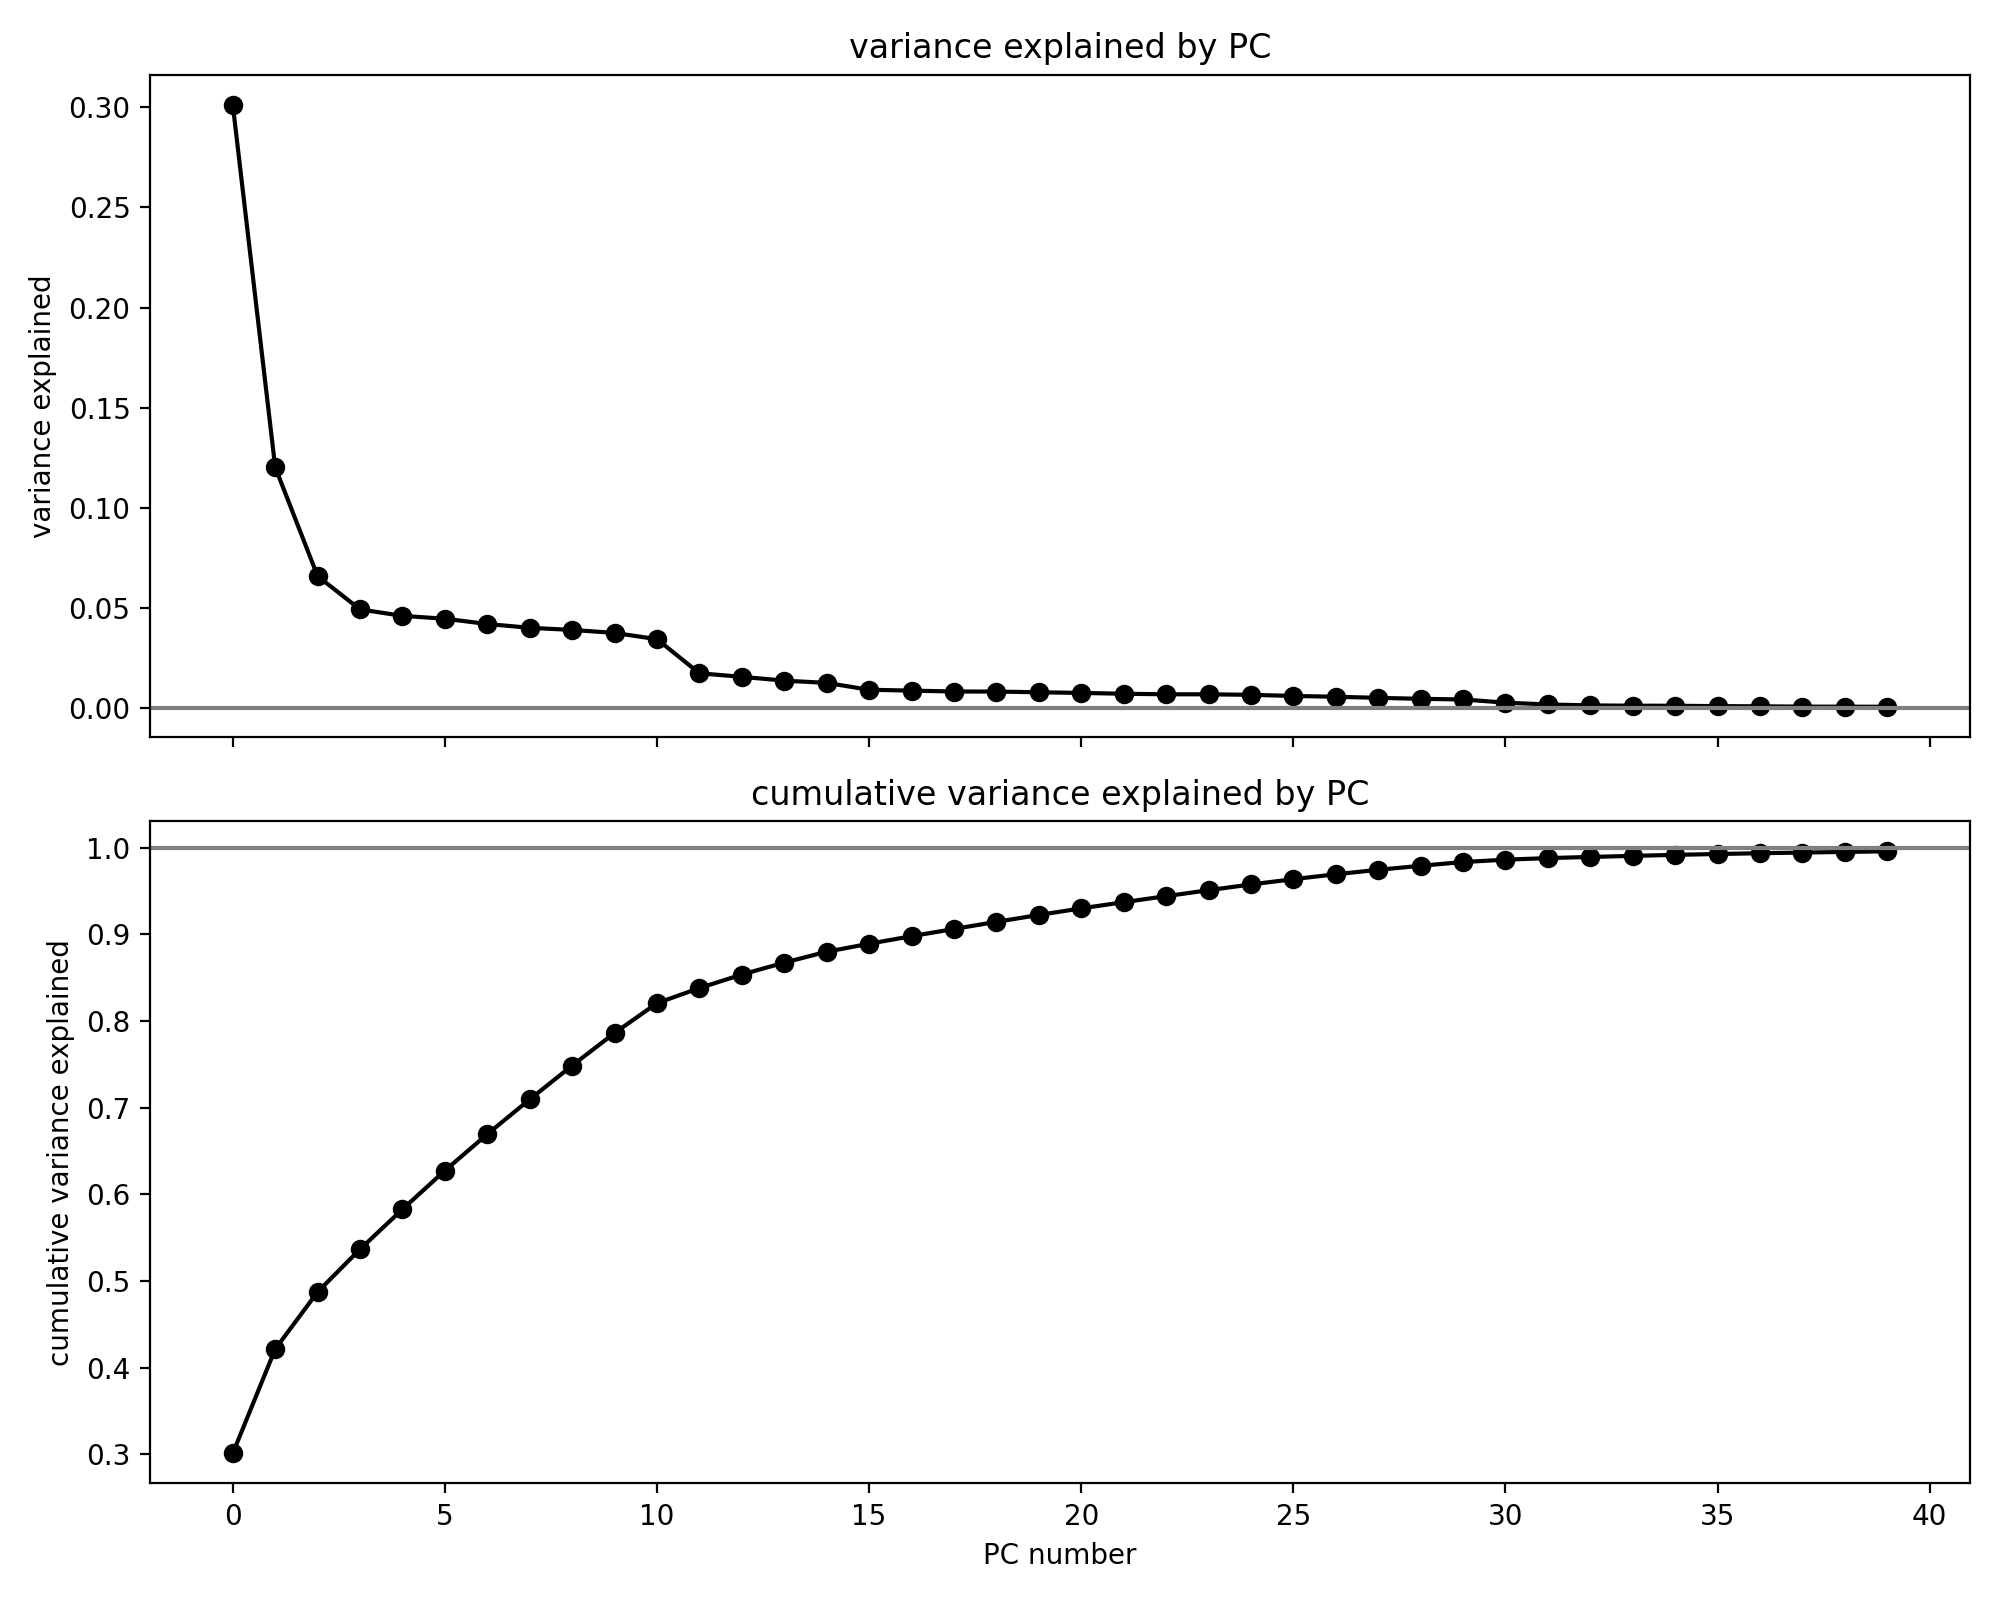

In [134]:
fig,ax = gvt.plot_PCA_var_explained(pca)

<IPython.core.display.Javascript object>


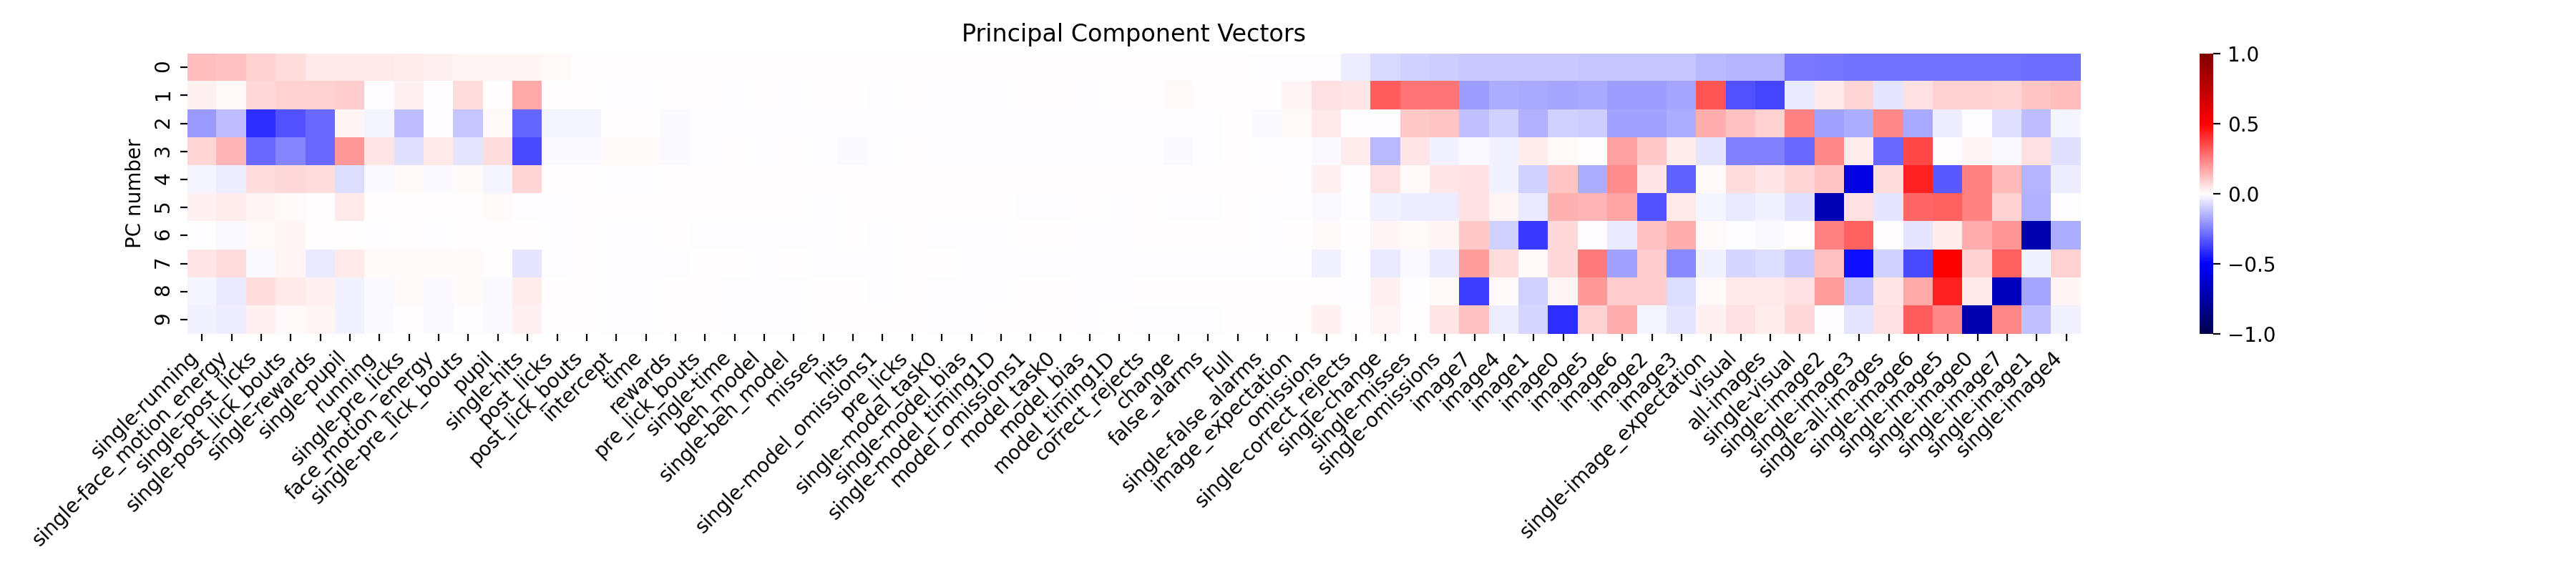

In [135]:
fig, ax = gvt.pc_component_heatmap(pca)

<IPython.core.display.Javascript object>


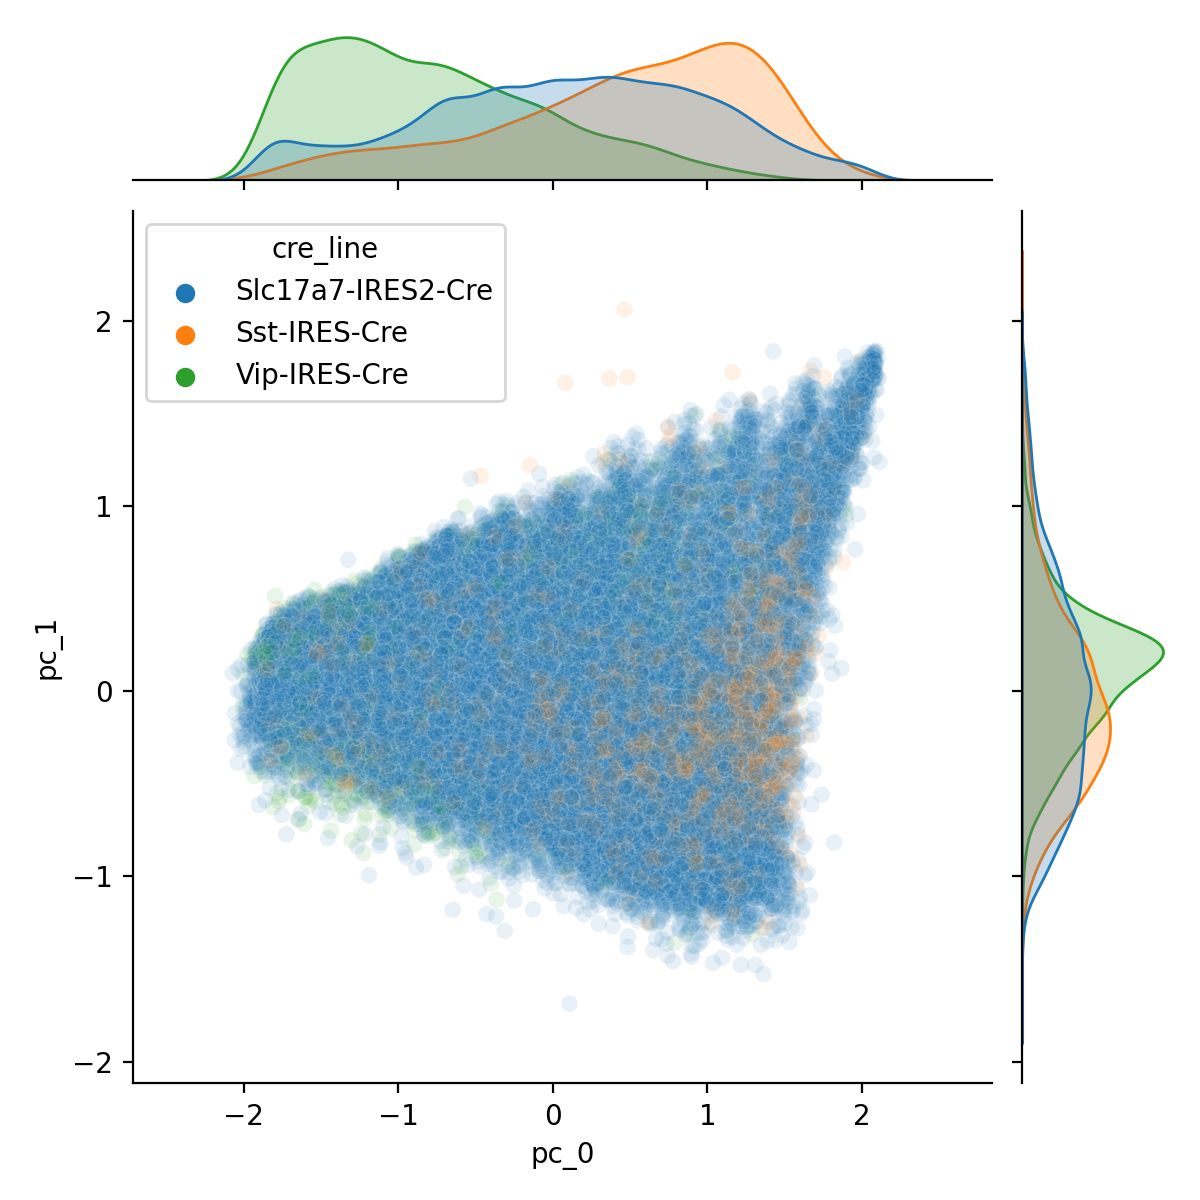

In [104]:
g = sns.jointplot(
    x="pc_0", 
    y="pc_1", 
    data=rsp,
    hue='cre_line',
    hue_order=np.sort(rsp['cre_line'].unique()),
    alpha=0.1,
    marginal_kws={'common_norm':False}
)

<IPython.core.display.Javascript object>


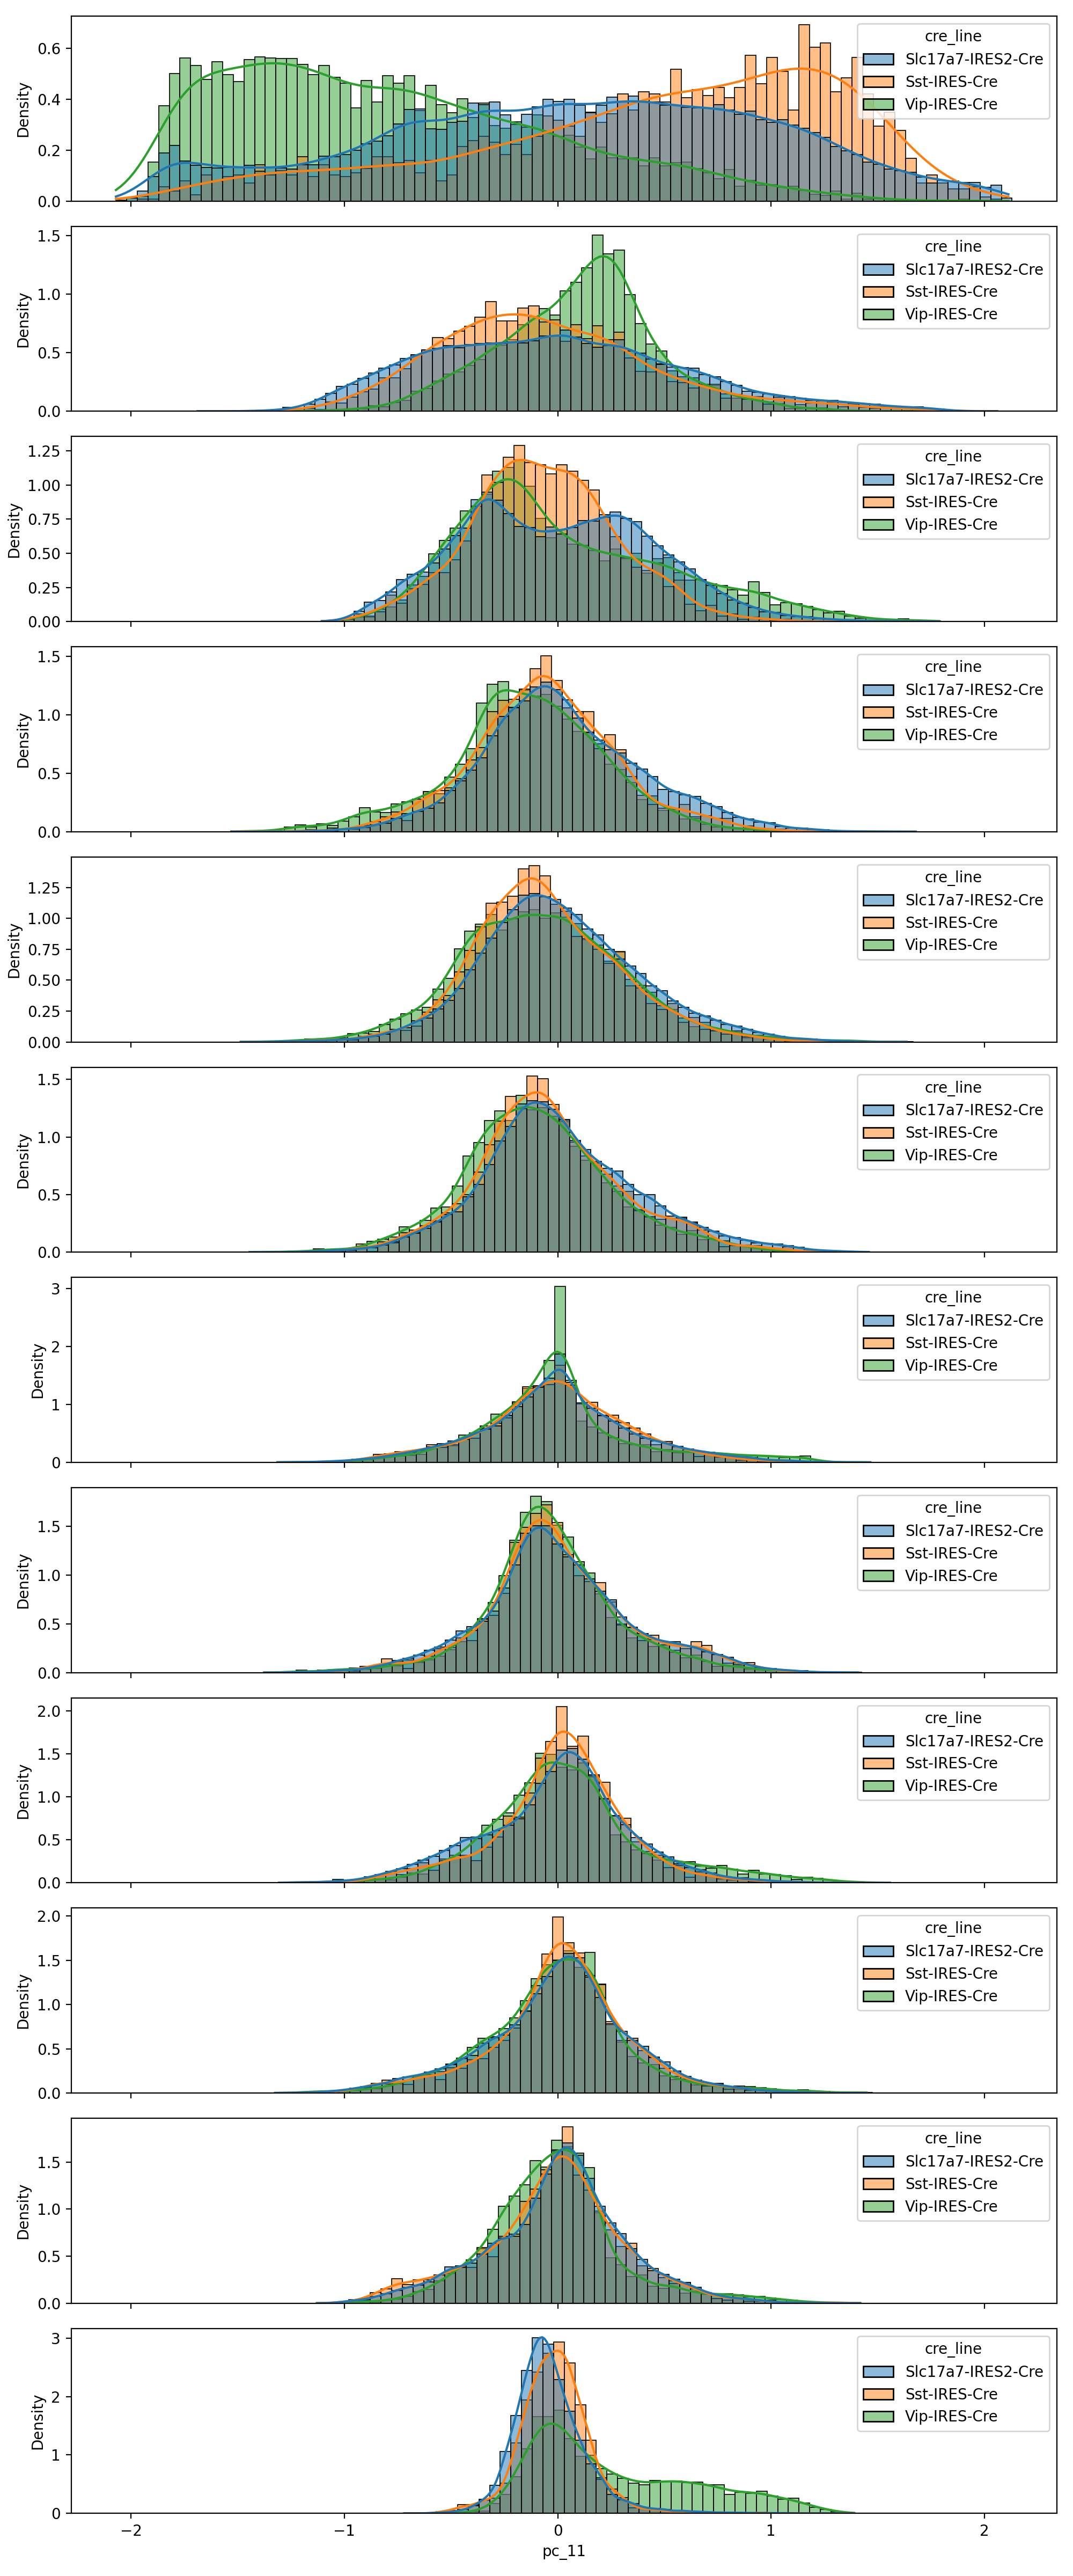

In [93]:
n_pcs_to_plot = 12
fig,ax=plt.subplots(n_pcs_to_plot,1,sharex=True,figsize=(10,2*n_pcs_to_plot))
for pc in range(n_pcs_to_plot):
    sns.histplot(
        rsp, 
        x='pc_{}'.format(pc),
        hue='cre_line',
        hue_order = np.sort(rsp['cre_line'].unique()),
        binwidth=0.05,
        ax = ax[pc],
        stat='density',
        kde=True,
        common_norm=False,
    )
fig.tight_layout()